<a href="https://colab.research.google.com/github/HG0304/CC6112-Treinamento-de-CNN/blob/main/Projeto-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 03 - Treinamento de CNN para Classificação de Imagens

---

## 📄 Informações do Projeto

| Item | Detalhes |
| :--- | :--- |
| **Disciplina** | CC6112 - Computação Gráfica |
| **Projeto** | Treinamento de CNN |

---

## 👥 Membros da Equipe

| Nome | RA |
| :--- | :--- |
| Hugo Emílio Nomura | 22.123.051-9 |
| Vitor Monteiro Vianna | 22.223.085-6 |

---

## 🎯 Objetivo da Tarefa

O objetivo principal deste projeto é selecionar uma base de dados de imagens no **Kaggle** e realizar o **treinamento completo de uma Rede Neural Convolucional (CNN)** para a classificação dessas imagens.

### 📝 Requisitos de Entrega:

O modelo treinado deve ser rigorosamente avaliado, e os seguintes resultados e análises devem ser exibidos:

* **Matriz de Confusão**
* **Precision (Precisão)**
* **Recall (Sensibilidade)**
* **Acurácia**
* **Análise de Overfitting (Sobreajuste)** - Demonstração visual do histórico de treinamento vs. validação.

# Resumo

- Preparar o conjunto de dados Kaggle "Bone Fracture Detection" localizado em "/root/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2".
-  Definir uma arquitetura do modelo CNN para treinar o modelo.
- Avaliar o desempenho usando métricas como acurácia, relatório de classificação e uma matriz de confusão, e analise o histórico de treinamento para verificar *overfitting*.
- Por fim, forneçer um resumo do desempenho do modelo na tarefa de detecção de fraturas ósseas.

## Preparando o conjunto de dados Kaggle

Carregando as imagens e seus rótulos correspondentes, realizando as etapas de pré-processamento necessárias, como redimensionar as imagens para um tamanho uniforme (128x128 pixels) e normalizar os valores dos pixels. Por fim, dividir o conjunto de dados em conjuntos de treinamento, validação e teste adequados para a CNN.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/bone-fracture-detection-computer-vision-project")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bone-fracture-detection-computer-vision-project' dataset.
Path to dataset files: /kaggle/input/bone-fracture-detection-computer-vision-project


In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import yaml

base_path = path

data_path = os.path.join(base_path, 'BoneFractureYolo8')

# Path to data.yaml
data_yaml_path = os.path.join(data_path, 'data.yaml')

# Load the data.yaml file
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Extract class names and number of classes
class_names = data_yaml['names']
num_classes = len(class_names)
print(f"\nClass names: {class_names}")
print(f"Number of classes: {num_classes}")

# Construct paths to the train images and labels directories
train_images_dir = os.path.join(data_path, 'train', 'images')
train_labels_dir = os.path.join(data_path, 'train', 'labels')

print(f"\n\nContents of {train_images_dir} (first 5 items):")
for i, item in enumerate(os.listdir(train_images_dir)):
    if i >= 5: break
    print(item)

print(f"\nContents of {train_labels_dir} (first 5 items):")
for i, item in enumerate(os.listdir(train_labels_dir)):
    if i >= 5: break
    print(item)


Class names: ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
Number of classes: 7


Contents of /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images (first 5 items):
image1_1872_png.rf.7c06f57af1282f7e5cbbf99df577f5ab.jpg
image1_383_png.rf.52b55542e0dff5fed975ca203c03b2e1.jpg
image1_6589_png.rf.eb8aa8731e9e01a6e7231ae792233f0b.jpg
image1_247_png.rf.79a4c58059673ac572cd1918f034ffb4.jpg
image1_615_png.rf.a28238ae05f715787d01b4a1a0a38246.jpg

Contents of /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels (first 5 items):
image1_2748_png.rf.568ada7b8ae0b71f076663983e4d70d0.txt
image1_1952_png.rf.affb8c1eef1e6fb8ef0eb5dbb34bc853.txt
image2_738_png.rf.9d550fec27301122da0d16121329dcbd.txt
image1_149_png.rf.ada624ba09aa493fb299f7bbc857abf7.txt
image1_641_png.rf.5af764be4c01a9cd54df4c1ffb237f09.txt


Como conjunto de dados já está dividido em diretórios `train`, `valid` e `test`, elimina a necessidade de `train_test_split`. Em vez disso, preciso carregar e pré-processar as imagens e seus rótulos correspondentes a partir dessas divisões pré-definidas. Isso envolve ler os arquivos de imagem, redimensioná-los, normalizar os valores dos pixels e extrair os rótulos de classe dos arquivos de texto associados, convertendo-os em *arrays* numéricos para o treinamento do modelo.

In [4]:
IMG_SIZE = 128

def load_and_preprocess_data(split_folder):
    images = []
    labels = []

    # Caminhos para imagens e rótulos dentro da divisão atual
    images_path = os.path.join(data_path, split_folder, 'images')
    labels_path = os.path.join(data_path, split_folder, 'labels')

    print(f"Loading data from: {images_path}")

    # Iterar sobre os arquivos de imagem no diretório de imagens da divisão atual
    for img_filename in os.listdir(images_path):
        # Construir o caminho completo da imagem
        img_file_path = os.path.join(images_path, img_filename)

        # Construir o caminho do arquivo de rótulo correspondente
        # Remover a extensão do arquivo e adicionar '.txt'
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_file_path = os.path.join(labels_path, label_filename)

        # Ler a imagem
        img = cv2.imread(img_file_path)
        if img is None: # Pular se o carregamento da imagem falhar
            print(f"Warning: Could not load image {img_filename}. Skipping.")
            continue

        # Converter BGR para RGB (OpenCV lê em BGR por padrão)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Redimensionar a imagem para dimensão uniforme
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Normalizar os valores dos pixels para ficarem entre 0 e 1
        img = img / 255.0

        images.append(img)

        # Ler o rótulo
        if os.path.exists(label_file_path):
            with open(label_file_path, 'r') as f:
                lines = f.readlines()
            if lines: # Verificar se o arquivo de rótulo não está vazio
                # Formato YOLO: class_id x_center y_center width height
                # Pegamos o primeiro class_id para classificação de rótulo único
                class_id = int(lines[0].strip().split(' ')[0])
                labels.append(class_id)
            else:
                print(f"Warning: Label file {label_filename} is empty. Skipping image {img_filename}.")
                images.pop() # Remover a imagem se nenhum rótulo válido for encontrado
        else:
            print(f"Warning: Label file {label_filename} not found. Skipping image {img_filename}.")
            images.pop() # Remover a imagem se nenhum arquivo de rótulo for encontrado

    return np.array(images), np.array(labels)

# Carregar dados para cada divisão (split)
X_train_new, y_train_new = load_and_preprocess_data('train')
X_val_new, y_val_new = load_and_preprocess_data('valid')
X_test_new, y_test_new = load_and_preprocess_data('test')

# Converter os rótulos para o formato one-hot encoding
y_train_one_hot = to_categorical(y_train_new, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_new, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_new, num_classes=num_classes)

print(f"\nTrain images shape: {X_train_new.shape}")
print(f"Train labels shape: {y_train_one_hot.shape}")
print(f"Validation images shape: {X_val_new.shape}")
print(f"Validation labels shape: {y_val_one_hot.shape}")
print(f"Test images shape: {X_test_new.shape}")
print(f"Test labels shape: {y_test_one_hot.shape}")

Loading data from: /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images
Loading data from: /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images
Loading data from: /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images

Train images shape: (1804, 128, 128, 3)
Train labels shape: (1804, 7)
Validation images shape: (173, 128, 128, 3)
Validation labels shape: (173, 7)
Test images shape: (83, 128, 128, 3)
Test labels shape: (83, 7)


##  Arquitetura do Modelo CNN

- Modificar a camada de entrada do modelo de Rede Neural Convolucional para corresponder às dimensões das imagens do conjunto de dados.
- Atualizar a camada densa final para ter o número correto de classes de saída com base nas categorias do conjunto de dados.

Nós definimos um novo modelo Sequencial com camadas `Conv2D`, `MaxPooling2D`, `Flatten`, `Dropout` e `Dense`, ajustando o formato de entrada (*input shape*) e o número de classes de saída de acordo com as instruções e os dados recém-carregados.

In [5]:
from tensorflow.keras import models, layers

new_model = models.Sequential()
new_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Flatten())
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(512, activation='relu'))
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(num_classes, activation='softmax'))

new_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,407 (49.37 MB)

 Trainable params: 12,942,407 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

Após definirmos a nova arquitetura do modelo para o conjunto de dados de detecção de fraturas ósseas. O próximo passo lógico é treinar o modelo modificado usando os dados de treinamento e validação pré-processados.

Com o Early Stopping e os geradores de dados configurados, agora vou modificar a célula de treinamento para usar esses componentes, permitindo que o modelo seja treinado com dados aumentados e pare de treinar automaticamente para evitar o overfitting.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Definir o Early Stopping
# Monitora a val_loss (perda de validação) e para o treinamento se ela não melhorar por 5 épocas.
# 'min_delta' é o limite para considerar uma melhora.
# 'restore_best_weights' garante que o modelo use os pesos da melhor época.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# 2. Configurar o Data Augmentation
# Definir um gerador de imagens para aumentar os dados de treinamento.
# Estas são algumas transformações comuns para imagens:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Para dados de validação, geralmente apenas reescalamos, sem aumento de dados (augmentation)
val_datagen = ImageDataGenerator()

# Preparar os geradores para alimentar o modelo
# Como X_train_new e X_val_new já estão pré-processados e em arrays numpy,
# podemos usar o método flow para gerar os batches aumentados.
# Certifique-se de que os labels (y_train_one_hot, y_val_one_hot) estão no formato correto (one-hot encoding).

# Convertendo os dados de treinamento e validação para o formato que o gerador espera
# (normalmente, o ImageDataGenerator espera dados não normalizados [0, 255] se for fazer a reescala)
# No entanto, como já normalizamos para [0,1], o generator não fará reescala a menos que especificado 'rescale=1./255'
# Como os dados já estão normalizados, não precisamos de rescale aqui.

train_generator = train_datagen.flow(
    X_train_new,
    y_train_one_hot,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val_new,
    y_val_one_hot,
    batch_size=32
)

In [7]:
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_new = new_model.fit(
    train_generator, # Usar o gerador para dados de treinamento aumentados
    epochs=50, # Aumentar o número de épocas, pois o early stopping irá parar quando necessário
    validation_data=val_generator, # Usar o gerador para dados de validação
    callbacks=[early_stopping] # Adicionar o callback de early stopping
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2089 - loss: 1.8187 - val_accuracy: 0.2890 - val_loss: 1.6659
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3146 - loss: 1.6738 - val_accuracy: 0.2832 - val_loss: 1.6236
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3480 - loss: 1.6112 - val_accuracy: 0.3584 - val_loss: 1.5257
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3704 - loss: 1.5633 - val_accuracy: 0.5202 - val_loss: 1.2941
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4187 - loss: 1.5039 - val_accuracy: 0.5202 - val_loss: 1.3346
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4262 - loss: 1.4890 - val_accuracy: 0.4220 - val_loss: 1.5018
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4108 - loss: 1.4689 - val_accuracy: 0.3988 - val_loss: 1.4971
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4412 - loss: 1.4597 - val_accuracy: 0.5202 - val_loss:

3/3 - 2s - 777ms/step - accuracy: 0.4458 - loss: 1.2836
Test Loss: 1.2836
Test Accuracy: 0.4458
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step

Classification Report:
                   precision    recall  f1-score   support

   elbow positive       0.33      0.31      0.32        13
 fingers positive       0.47      0.64      0.54        22
 forearm fracture       0.30      0.23      0.26        13
 humerus fracture       0.00      0.00      0.00         0
          humerus       0.50      0.14      0.22        14
shoulder fracture       0.61      0.93      0.74        15
   wrist positive       0.00      0.00      0.00         6

         accuracy                           0.45        83
        macro avg       0.32      0.32      0.30        83
     weighted avg       0.42      0.45      0.40        83



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

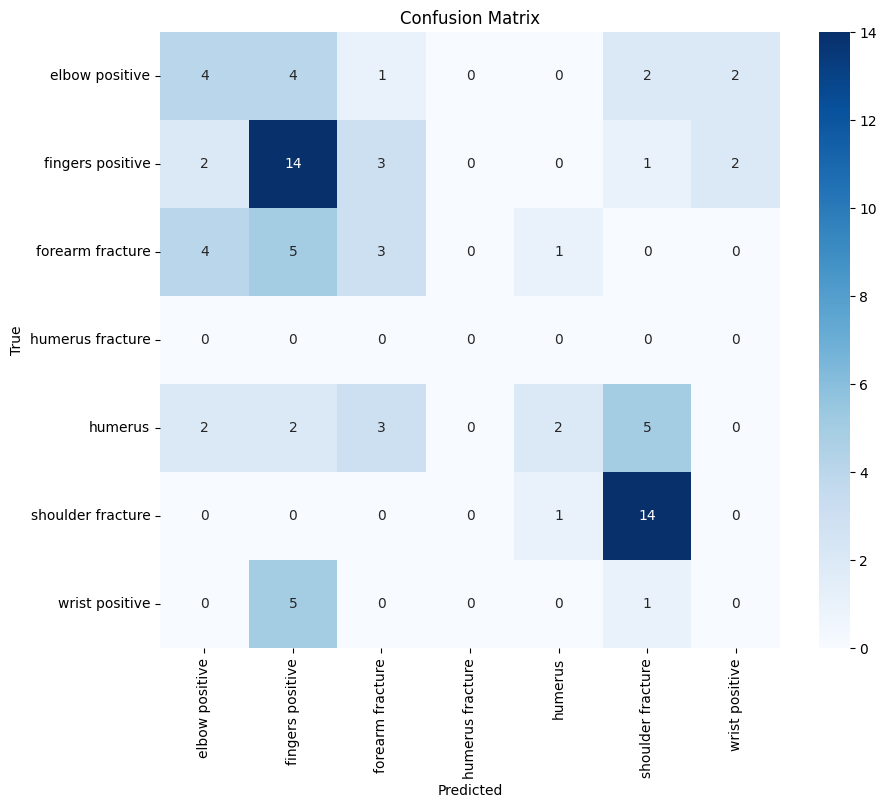

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

loss, accuracy = new_model.evaluate(X_test_new, y_test_one_hot, verbose=2)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions for the test set
y_pred = new_model.predict(X_test_new)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, labels=range(num_classes)))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=range(num_classes))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

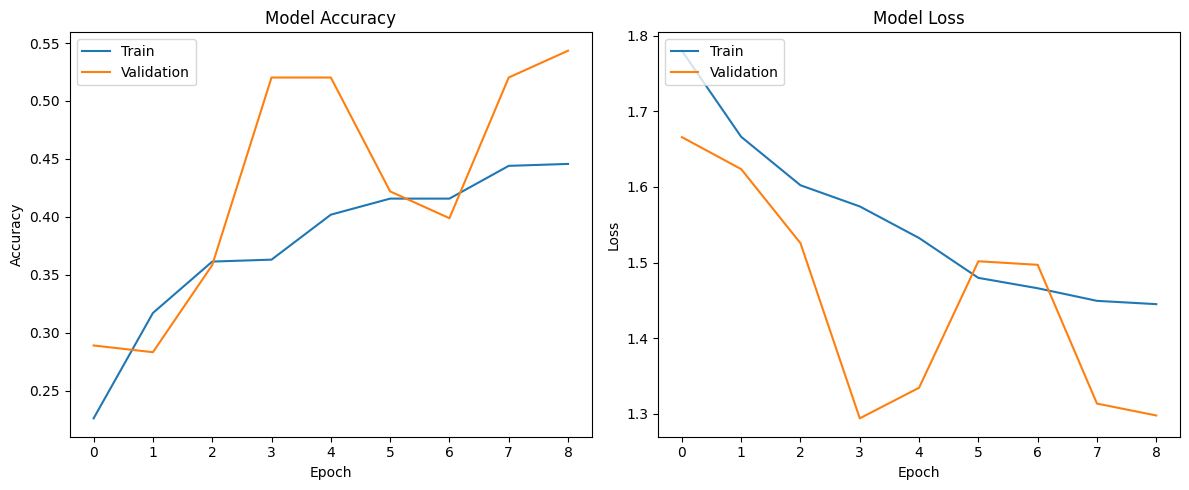

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_new.history['accuracy'])
plt.plot(history_new.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_new.history['loss'])
plt.plot(history_new.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

---

## Sumário dos Resultados:

*   **Matriz de Confusão:** Visualiza o desempenho do algoritmo de classificação, mostrando o número de previsões corretas e incorretas para cada classe.
*   **Precision (Precisão):** Indica a proporção de identificações positivas que foram realmente corretas (verdadeiros positivos dividido por verdadeiros positivos + falsos positivos).
*   **Recall (Sensibilidade):** Indica a proporção de positivos reais que foram identificados corretamente (verdadeiros positivos dividido por verdadeiros positivos + falsos negativos).
*   **Acurácia:** A proporção de previsões corretas do modelo sobre o total de previsões.
*   **Análise de Overfitting (Sobreajuste):** Demonstração visual do histórico de treinamento vs. validação, mostrando como as curvas de acurácia e perda se comportaram para identificar se o modelo generaliza bem para dados não vistos.